In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data-ICIAR/Reinhard/train/'
test_dir = "data-ICIAR/Reinhard/test/"

extracted_features_dir = "extracted_features/"
model_name = "Reinhard_Xception_concate"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 512, 512
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

# print("*"*30)
# for root,dirs,files in os.walk(validation_dir):
#     print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ICIAR/Reinhard/train/ 0
data-ICIAR/Reinhard/train/Benign 1155
data-ICIAR/Reinhard/train/InSitu 1155
data-ICIAR/Reinhard/train/Invasive 1155
data-ICIAR/Reinhard/train/Normal 1155
******************************
data-ICIAR/Reinhard/test/ 0
data-ICIAR/Reinhard/test/Benign 25
data-ICIAR/Reinhard/test/InSitu 25
data-ICIAR/Reinhard/test/Invasive 25
data-ICIAR/Reinhard/test/Normal 25


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

# test_generator_without_aug = test_datagen.flow_from_directory(
#     test_dir_whithout_aug,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     seed = random_seed,
#     shuffle = False,
#     class_mode='categorical')

Found 3468 images belonging to 4 classes.
Found 1152 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3468
nb_validation_samples: 1152

predict_size_train: 109
predict_size_validation: 36
nb_test_samples: 100
predict_size_test: 4

 num_classes: 4


In [69]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [70]:
model = Xception(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

In [71]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [72]:
# print(model.layers[11].name)

In [73]:
c1 = model.layers[16].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[26].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[36].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[126].output
c4 = GlobalAveragePooling2D()(c4) 

con = concatenate([c2, c3, c4])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [74]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [75]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [76]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [77]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [78]:
dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.001, beta_1=0.6, beta_2=0.8, amsgrad=True)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 3468 samples, validate on 1152 samples
Epoch 1/1000
 - 1s - loss: 1.0959 - acc: 0.5917 - val_loss: 0.6959 - val_acc: 0.7622
Epoch 2/1000
 - 1s - loss: 0.7033 - acc: 0.7393 - val_loss: 0.5461 - val_acc: 0.8281
Epoch 3/1000
 - 0s - loss: 0.5925 - acc: 0.7843 - val_loss: 0.4924 - val_acc: 0.8359
Epoch 4/1000
 - 0s - loss: 0.5300 - acc: 0.8045 - val_loss: 0.4238 - val_acc: 0.8455
Epoch 5/1000
 - 0s - loss: 0.4486 - acc: 0.8423 - val_loss: 0.3519 - val_acc: 0.8863
Epoch 6/1000
 - 0s - loss: 0.4129 - acc: 0.8581 - val_loss: 0.3191 - val_acc: 0.8993
Epoch 7/1000
 - 0s - loss: 0.3759 - acc: 0.8622 - val_loss: 0.2882 - val_acc: 0.9062
Epoch 8/1000
 - 0s - loss: 0.3544 - acc: 0.8803 - val_loss: 0.2550 - val_acc: 0.9271
Epoch 9/1000
 - 0s - loss: 0.3239 - acc: 0.8855 - val_loss: 0.2276 - val_acc: 0.9340
Epoch 10/1000
 - 0s - loss: 0.2842 - acc: 0.9129 - val_loss: 0.2245 - val_acc: 0.9462
Epoch 11/1000
 - 0s - loss: 0.2792 - acc: 0.8979 - val_loss: 0.1834 - val_acc: 0.9592
Epoch 12/1000
 

Epoch 96/1000
 - 0s - loss: 0.0319 - acc: 0.9948 - val_loss: 0.0132 - val_acc: 0.9991
Epoch 97/1000
 - 0s - loss: 0.0327 - acc: 0.9931 - val_loss: 0.0163 - val_acc: 0.9974
Epoch 98/1000
 - 0s - loss: 0.0280 - acc: 0.9965 - val_loss: 0.0127 - val_acc: 0.9991
Epoch 99/1000
 - 0s - loss: 0.0305 - acc: 0.9945 - val_loss: 0.0119 - val_acc: 0.9991
Epoch 100/1000
 - 0s - loss: 0.0289 - acc: 0.9939 - val_loss: 0.0145 - val_acc: 0.9991
Epoch 101/1000
 - 0s - loss: 0.0333 - acc: 0.9916 - val_loss: 0.0126 - val_acc: 0.9991
Epoch 102/1000
 - 0s - loss: 0.0305 - acc: 0.9945 - val_loss: 0.0112 - val_acc: 1.0000
Epoch 103/1000
 - 0s - loss: 0.0292 - acc: 0.9954 - val_loss: 0.0163 - val_acc: 0.9983
Epoch 104/1000
 - 0s - loss: 0.0283 - acc: 0.9954 - val_loss: 0.0133 - val_acc: 0.9983
Epoch 105/1000
 - 0s - loss: 0.0274 - acc: 0.9951 - val_loss: 0.0142 - val_acc: 0.9974
Epoch 106/1000
 - 0s - loss: 0.0255 - acc: 0.9957 - val_loss: 0.0151 - val_acc: 0.9983
Epoch 107/1000
 - 0s - loss: 0.0262 - acc: 0.99

Epoch 191/1000
 - 0s - loss: 0.0159 - acc: 0.9965 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 192/1000
 - 0s - loss: 0.0159 - acc: 0.9974 - val_loss: 0.0068 - val_acc: 0.9983
Epoch 193/1000
 - 0s - loss: 0.0112 - acc: 0.9991 - val_loss: 0.0059 - val_acc: 0.9991
Epoch 194/1000
 - 0s - loss: 0.0109 - acc: 0.9991 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 195/1000
 - 0s - loss: 0.0138 - acc: 0.9977 - val_loss: 0.0056 - val_acc: 0.9991
Epoch 196/1000
 - 0s - loss: 0.0126 - acc: 0.9980 - val_loss: 0.0068 - val_acc: 0.9991
Epoch 197/1000
 - 0s - loss: 0.0142 - acc: 0.9980 - val_loss: 0.0065 - val_acc: 1.0000
Epoch 198/1000
 - 0s - loss: 0.0139 - acc: 0.9971 - val_loss: 0.0062 - val_acc: 0.9991
Epoch 199/1000
 - 0s - loss: 0.0130 - acc: 0.9986 - val_loss: 0.0072 - val_acc: 0.9991
Epoch 200/1000
 - 0s - loss: 0.0125 - acc: 0.9980 - val_loss: 0.0069 - val_acc: 0.9991
Epoch 201/1000
 - 0s - loss: 0.0136 - acc: 0.9971 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 202/1000
 - 0s - loss: 0.0126 - acc: 

 - 0s - loss: 0.0074 - acc: 0.9994 - val_loss: 0.0044 - val_acc: 0.9991
Epoch 286/1000
 - 0s - loss: 0.0104 - acc: 0.9986 - val_loss: 0.0049 - val_acc: 0.9991
Epoch 287/1000
 - 0s - loss: 0.0094 - acc: 0.9983 - val_loss: 0.0047 - val_acc: 0.9983
Epoch 288/1000
 - 0s - loss: 0.0090 - acc: 0.9991 - val_loss: 0.0050 - val_acc: 0.9991
Epoch 289/1000
 - 0s - loss: 0.0082 - acc: 0.9994 - val_loss: 0.0043 - val_acc: 0.9991
Epoch 290/1000
 - 0s - loss: 0.0085 - acc: 0.9991 - val_loss: 0.0044 - val_acc: 0.9991
Epoch 291/1000
 - 0s - loss: 0.0093 - acc: 0.9980 - val_loss: 0.0049 - val_acc: 0.9991
Epoch 292/1000
 - 0s - loss: 0.0080 - acc: 0.9994 - val_loss: 0.0039 - val_acc: 0.9991
Epoch 293/1000
 - 0s - loss: 0.0067 - acc: 0.9991 - val_loss: 0.0044 - val_acc: 0.9991
Epoch 294/1000
 - 0s - loss: 0.0077 - acc: 0.9991 - val_loss: 0.0045 - val_acc: 0.9983
Epoch 295/1000
 - 0s - loss: 0.0077 - acc: 0.9988 - val_loss: 0.0045 - val_acc: 0.9991
Epoch 296/1000
 - 0s - loss: 0.0090 - acc: 0.9991 - val_lo

Epoch 380/1000
 - 0s - loss: 0.0067 - acc: 0.9997 - val_loss: 0.0041 - val_acc: 0.9991
Epoch 381/1000
 - 0s - loss: 0.0071 - acc: 0.9991 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 382/1000
 - 0s - loss: 0.0092 - acc: 0.9977 - val_loss: 0.0035 - val_acc: 0.9991
Epoch 383/1000
 - 0s - loss: 0.0064 - acc: 0.9991 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 384/1000
 - 0s - loss: 0.0069 - acc: 0.9986 - val_loss: 0.0033 - val_acc: 0.9991
Epoch 385/1000
 - 0s - loss: 0.0068 - acc: 0.9994 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 386/1000
 - 0s - loss: 0.0067 - acc: 0.9991 - val_loss: 0.0034 - val_acc: 0.9991
Epoch 387/1000
 - 0s - loss: 0.0056 - acc: 0.9997 - val_loss: 0.0037 - val_acc: 0.9991
Epoch 388/1000
 - 0s - loss: 0.0061 - acc: 0.9991 - val_loss: 0.0039 - val_acc: 0.9991
Epoch 389/1000
 - 0s - loss: 0.0069 - acc: 0.9994 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 390/1000
 - 0s - loss: 0.0073 - acc: 0.9986 - val_loss: 0.0074 - val_acc: 0.9991
Epoch 391/1000
 - 0s - loss: 0.0069 - acc: 

 - 0s - loss: 0.0060 - acc: 0.9994 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 475/1000
 - 0s - loss: 0.0064 - acc: 0.9991 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 476/1000
 - 0s - loss: 0.0052 - acc: 0.9994 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 477/1000
 - 0s - loss: 0.0061 - acc: 0.9986 - val_loss: 0.0034 - val_acc: 0.9983
Epoch 478/1000
 - 0s - loss: 0.0053 - acc: 0.9994 - val_loss: 0.0029 - val_acc: 0.9991
Epoch 479/1000
 - 0s - loss: 0.0070 - acc: 0.9986 - val_loss: 0.0036 - val_acc: 0.9991
Epoch 480/1000
 - 0s - loss: 0.0050 - acc: 0.9994 - val_loss: 0.0027 - val_acc: 0.9991
Epoch 481/1000
 - 0s - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0033 - val_acc: 0.9991
Epoch 482/1000
 - 0s - loss: 0.0058 - acc: 0.9994 - val_loss: 0.0030 - val_acc: 0.9991
Epoch 483/1000
 - 0s - loss: 0.0075 - acc: 0.9974 - val_loss: 0.0046 - val_acc: 0.9991
Epoch 484/1000
 - 0s - loss: 0.0057 - acc: 0.9991 - val_loss: 0.0034 - val_acc: 0.9983
Epoch 485/1000
 - 0s - loss: 0.0063 - acc: 0.9988 - val_lo

Epoch 569/1000
 - 0s - loss: 0.0035 - acc: 0.9997 - val_loss: 0.0030 - val_acc: 0.9983
Epoch 570/1000
 - 0s - loss: 0.0063 - acc: 0.9986 - val_loss: 0.0032 - val_acc: 0.9991
Epoch 571/1000
 - 0s - loss: 0.0038 - acc: 0.9997 - val_loss: 0.0030 - val_acc: 0.9991
Epoch 572/1000
 - 0s - loss: 0.0050 - acc: 0.9983 - val_loss: 0.0038 - val_acc: 0.9991
Epoch 573/1000
 - 0s - loss: 0.0055 - acc: 0.9991 - val_loss: 0.0045 - val_acc: 0.9991
Epoch 574/1000
 - 0s - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 575/1000
 - 0s - loss: 0.0051 - acc: 0.9994 - val_loss: 0.0033 - val_acc: 0.9991
Epoch 576/1000
 - 0s - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 0.9991
Epoch 577/1000
 - 0s - loss: 0.0039 - acc: 0.9997 - val_loss: 0.0034 - val_acc: 0.9991
Epoch 578/1000
 - 0s - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0027 - val_acc: 0.9991
Epoch 579/1000
 - 0s - loss: 0.0045 - acc: 0.9994 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 580/1000
 - 0s - loss: 0.0060 - acc: 

 - 0s - loss: 0.0042 - acc: 0.9994 - val_loss: 0.0027 - val_acc: 0.9991
Epoch 664/1000
 - 0s - loss: 0.0038 - acc: 0.9997 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 665/1000
 - 0s - loss: 0.0039 - acc: 0.9994 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 666/1000
 - 0s - loss: 0.0045 - acc: 0.9994 - val_loss: 0.0030 - val_acc: 0.9991
Epoch 667/1000
 - 0s - loss: 0.0046 - acc: 0.9991 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 668/1000
 - 0s - loss: 0.0043 - acc: 0.9994 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 669/1000
 - 0s - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 0.9991
Epoch 670/1000
 - 0s - loss: 0.0053 - acc: 0.9988 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 671/1000
 - 0s - loss: 0.0045 - acc: 0.9994 - val_loss: 0.0041 - val_acc: 0.9983
Epoch 672/1000
 - 0s - loss: 0.0052 - acc: 0.9994 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 673/1000
 - 0s - loss: 0.0045 - acc: 0.9991 - val_loss: 0.0023 - val_acc: 0.9991
Epoch 674/1000
 - 0s - loss: 0.0038 - acc: 0.9997 - val_lo

Epoch 758/1000
 - 0s - loss: 0.0028 - acc: 0.9997 - val_loss: 0.0028 - val_acc: 0.9991
Epoch 759/1000
 - 0s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 0.9991
Epoch 760/1000
 - 0s - loss: 0.0035 - acc: 0.9994 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 761/1000
 - 0s - loss: 0.0044 - acc: 0.9991 - val_loss: 0.0026 - val_acc: 0.9991
Epoch 762/1000
 - 0s - loss: 0.0032 - acc: 0.9994 - val_loss: 0.0025 - val_acc: 0.9991
Epoch 763/1000
 - 0s - loss: 0.0034 - acc: 0.9997 - val_loss: 0.0034 - val_acc: 0.9991
Epoch 764/1000
 - 0s - loss: 0.0030 - acc: 0.9997 - val_loss: 0.0028 - val_acc: 0.9991
Epoch 765/1000
 - 0s - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 0.9991
Epoch 766/1000
 - 0s - loss: 0.0035 - acc: 0.9997 - val_loss: 0.0030 - val_acc: 0.9991
Epoch 767/1000
 - 0s - loss: 0.0039 - acc: 0.9991 - val_loss: 0.0029 - val_acc: 0.9991
Epoch 768/1000
 - 0s - loss: 0.0033 - acc: 0.9997 - val_loss: 0.0027 - val_acc: 0.9991
Epoch 769/1000
 - 0s - loss: 0.0035 - acc: 

 - 0s - loss: 0.0028 - acc: 0.9997 - val_loss: 0.0024 - val_acc: 0.9991
Epoch 853/1000
 - 0s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 854/1000
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 0.9991
Epoch 855/1000
 - 0s - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 856/1000
 - 0s - loss: 0.0030 - acc: 0.9994 - val_loss: 0.0028 - val_acc: 0.9983
Epoch 857/1000
 - 0s - loss: 0.0032 - acc: 0.9994 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 858/1000
 - 0s - loss: 0.0035 - acc: 0.9994 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 859/1000
 - 0s - loss: 0.0037 - acc: 0.9991 - val_loss: 0.0024 - val_acc: 0.9991
Epoch 860/1000
 - 0s - loss: 0.0030 - acc: 0.9997 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 861/1000
 - 0s - loss: 0.0027 - acc: 0.9994 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 862/1000
 - 0s - loss: 0.0032 - acc: 0.9997 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 863/1000
 - 0s - loss: 0.0038 - acc: 0.9994 - val_lo

Epoch 947/1000
 - 0s - loss: 0.0031 - acc: 0.9994 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 948/1000
 - 0s - loss: 0.0032 - acc: 0.9994 - val_loss: 0.0025 - val_acc: 0.9991
Epoch 949/1000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 0.9991
Epoch 950/1000
 - 0s - loss: 0.0025 - acc: 0.9997 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 951/1000
 - 0s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 0.9991
Epoch 952/1000
 - 0s - loss: 0.0033 - acc: 0.9994 - val_loss: 0.0020 - val_acc: 0.9991
Epoch 953/1000
 - 0s - loss: 0.0031 - acc: 0.9997 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 954/1000
 - 0s - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 955/1000
 - 0s - loss: 0.0039 - acc: 0.9991 - val_loss: 0.0019 - val_acc: 0.9991
Epoch 956/1000
 - 0s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 0.9991
Epoch 957/1000
 - 0s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 0.9991
Epoch 958/1000
 - 0s - loss: 0.0027 - acc: 

In [79]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.94


Confusion Matrix
[[21  2  0  2]
 [ 1 24  0  0]
 [ 0  1 24  0]
 [ 0  0  0 25]]


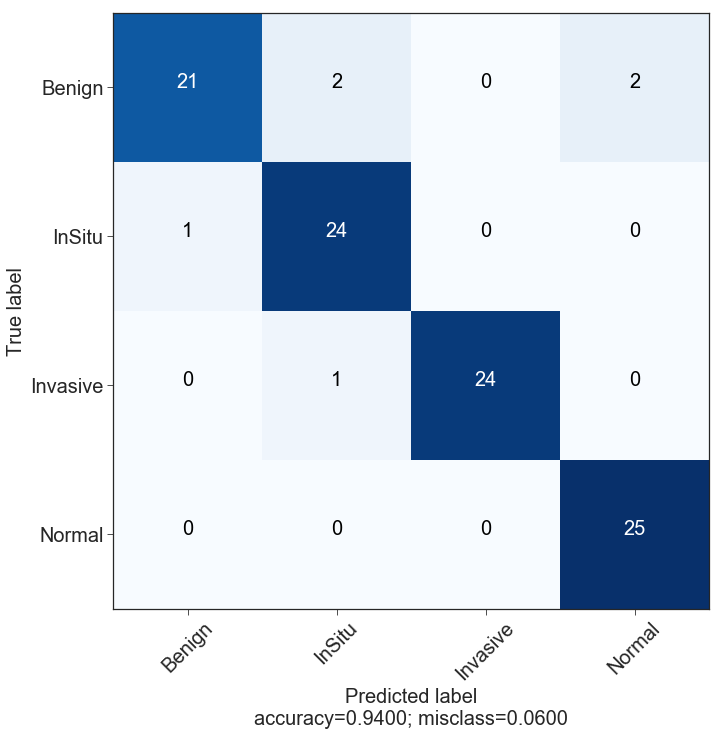

In [80]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [81]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[21  2  0  2]
 [ 1 24  0  0]
 [ 0  1 24  0]
 [ 0  0  0 25]]
              precision    recall  f1-score   support

      Benign       0.95      0.84      0.89        25
    Invasive       0.89      0.96      0.92        25
      Normal       1.00      0.96      0.98        25
      InSitu       0.93      1.00      0.96        25

   micro avg       0.94      0.94      0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [82]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  95.45454545454545
Specificity :  92.3076923076923


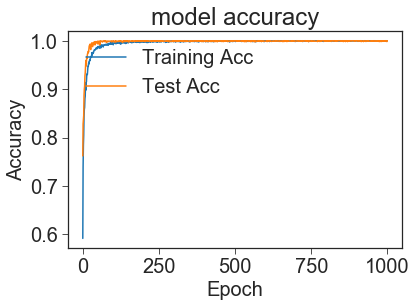

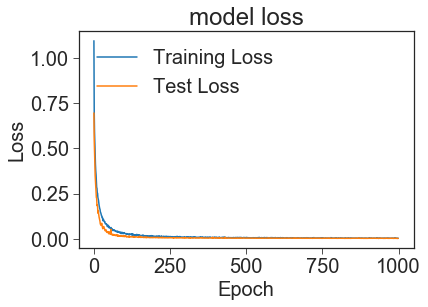

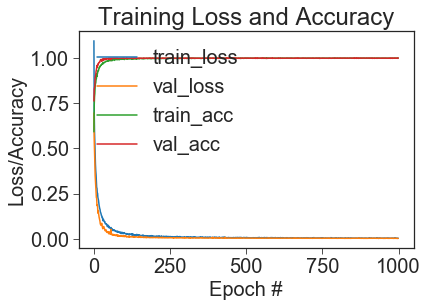

In [83]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")